# Galaxy Morphology EDA & Classification 

## The data for our classifications and EDA were acquired from the Sloan Digital Sky Server using SQL Queries 

### The URL for the dataset was acquired can be found [here](https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx#&&history=description+zooSpec+U).

In [51]:
from utils.mypytable import MyPyTable 
import utils.plot_utils as plot_utils
import importlib
import utils.myclassifiers
importlib.reload(utils.myclassifiers)
from utils.myclassifiers import MyDecisionTreeClassifier
from utils.myclassifiers import MyKNeighborsClassifier
from utils.myclassifiers import MyDummyClassifier
from utils.myclassifiers import MyNaiveBayesClassifier

import utils.myevaluation
importlib.reload(utils.myevaluation)
import utils.myevaluation as myevaluation
from itertools import chain
import utils.myutils as utils
importlib.reload(utils)
importlib.reload(plot_utils)
table = MyPyTable()
file_name = 'Skyserver_SQL4_21_2022 12_41_18 AM.csv'
table.load_from_file('input_folder/' + file_name)

summary_table = table.compute_summary_statistics(['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'ra', 'dec', 'z', 'zWarning', 'waveMin', 'plateSN2', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux'])
summary_table.pretty_print()

attribute                   min             max             mid             avg        median
--------------  ---------------  --------------  --------------  --------------  ------------
p_el                0               1               0.5               0.554168      0.603
p_cw                0               1               0.5               0.0685276     0.014
p_acw               0               1               0.5               0.0754504     0.019
p_edge              0               1               0.5               0.200613      0.129
p_dk                0               1               0.5               0.0705617     0.053
p_mg                0               0.957           0.4785            0.0306083     0
ra                  0.00647288    359.853         179.93            202.573       189.058
dec                -3.74796        66.3173         31.2847            4.72291      -0.288937
z                   0.0100696       0.693921        0.351995          0.106037      0.0977301

In [52]:
fraction_cols = ['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg']
utils.discretize_to_single_col(table.data, table.column_names, fraction_cols)
table.column_names.append('morph')
table.drop_cols(fraction_cols)

## Class Distribution

#### We are hoping to train our model on the class label for morphology classification which is a system used by astronomers to divide galaxies into groups based on their visual appearance.

#### In order to ensure that we can fit a good model to the data, having a distribution of class labels that are not too skewed so as to be overly abundant or lacking in some versus others 

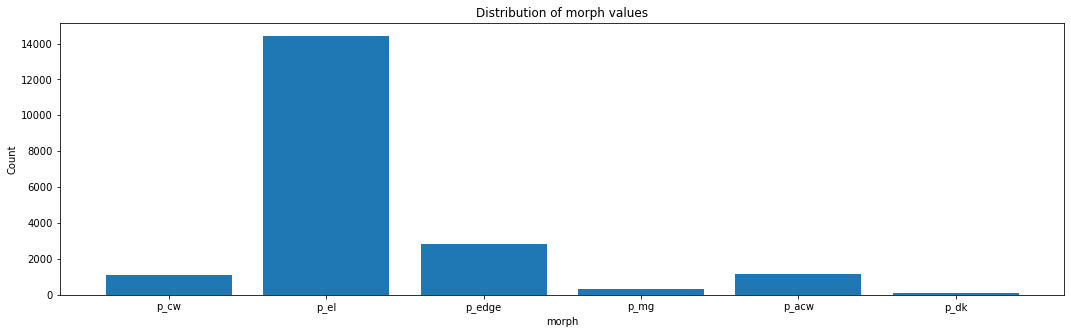

In [53]:
col = 'morph'
table.data = [row for row in table.data if len(row) == len(table.column_names)]
vals,counts = utils.get_categorical_frequencies(table.data, table.column_names, col)
plot_utils.categorical_frequency_bar_plot(col, vals, counts)

#### From our initial EDA we see that our class distribution .......

## A Closer Look: Features of Interest

#### Like the distributions of class lables we also used the opportunity for EDA to look into whether or not there were any features within the dataset that have high or low correlations with other attributes/class labels so as to gain intuition for potential pruning strategies or attributes to eliminate to reduce overfitting

###

### Preliminary Classification

In [54]:

cols_to_remove = ['specObjID', 'plate', 'mjd', 'fiberID', 'class', 'morph']
print(table.column_names)
print(table.data[0])
print(table.get_shape())
target_vals = table.get_column('morph')
table.drop_cols(cols_to_remove)
print(len(table.data))






['specObjID', 'plate', 'mjd', 'fiberID', 'class', 'ra', 'dec', 'z', 'zWarning', 'waveMin', 'plateSN2', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux', 'h_alpha_flux', 'nii_6548_flux', 'sii_6717_flux', 'sii_6731_flux', 'morph']
[3.0062217405244416e+17, 267.0, 51608.0, 25.0, 'GALAXY', 149.11298, -0.34882857, 0.08976489, 0.0, 3808.904, 19.5308, 0.755389, 3.930826, 5.777008, 14.4717, 2.30201, 13.2498, 4.907803, -0.3184069, 66.26616, 16.53776, 19.73699, 10.87834, 'p_edge']
(20000, 24)
20000


In [55]:
data = table.data[:1000]

X_train_idx_folds, X_test_idx_folds = myevaluation.stratified_kfold_cross_validation(
    data, target_vals, n_splits=3)

X_train = [[data[idx] for idx in fold] for fold in X_train_idx_folds]
y_train = [[target_vals[idx] for idx in fold]
            for fold in X_train_idx_folds]
X_test = [[data[idx] for idx in fold] for fold in X_test_idx_folds]
y_test = [[target_vals[idx] for idx in fold]
            for fold in X_test_idx_folds]

knn = MyKNeighborsClassifier(2)
dummy = MyDummyClassifier()
bayes = MyNaiveBayesClassifier()
# dec_tree = MyDecisionTreeClassifier()

classifier_names = ['dummy', 'knn']
models = [dummy, knn]
preds = [[] for _ in models]

for i in range(len(X_train)):
    print(i)
    for j in range(len(models)):
        print(j)
        models[j].fit(X_train[i], y_train[i])
        preds[j] += models[j].predict(X_test[i])

# converting 2d list into 1d
# using chain.from_iterables
y_test = list(chain.from_iterable(y_test))

for i in range(len(preds)):
    myevaluation.cross_val_stats(classifier_names[i], y_test, preds[i])

0
0
1
1
0
1
2
0
1
----------
Classifier: dummy
----------
----------
Accuracy: 0.704
----------
Error Rate: 0.29600000000000004
----------
Confusion Matrix: [[0, 59, 0, 0, 0, 0], [0, 704, 0, 0, 0, 0], [0, 142, 0, 0, 0, 0], [0, 16, 0, 0, 0, 0], [0, 75, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0]]
----------
Classifier: knn
----------
----------
Accuracy: 0.469
----------
Error Rate: 0.531
----------
Confusion Matrix: [[0, 47, 12, 0, 0, 0], [120, 417, 167, 0, 0, 0], [0, 96, 46, 0, 0, 0], [6, 10, 0, 0, 0, 0], [0, 3, 66, 0, 6, 0], [0, 3, 1, 0, 0, 0]]


#### Information about the dataset itself, e.g., the attributes and attribute types, the number of instances, and the attribute being used as the label.
#### Relevant summary statistics about the dataset.
#### Data visualizations highlighting important/interesting aspects of your dataset. Visualizations may include frequency distributions, comparisons of attributes (scatterplot, multiple frequency diagrams), box and whisker plots, etc. The goal is not to include all possible diagrams, but instead to select and highlight diagrams that provide insight about the dataset itself.
#### Note that this section must describe the above (in paragraph form) and not just provide diagrams and statistics. Also, each figure included must have a figure caption (Figure number and textual description) that is referenced from the text (e.g., “Figure 2 shows a frequency diagram for ...”).
